<a href="https://colab.research.google.com/github/wolfisberg/zhaw-ba-online/blob/main/deepf0/DEEP_F0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install mir_eval

     |████████████████████████████████| 92kB 6.7MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.6-cp37-none-any.whl size=96515 sha256=567d6ccccb5d9c64971079954e9e7428568af61b2a833ca2ef2c12432f366e2f
  Stored in directory: /root/.cache/pip/wheels/49/ce/30/730fa72addf275e49d90683b01b3613048b4be3bf7ff8eb6ec
Successfully built mir-eval


In [1]:
import os
import numpy as np
import tensorflow as tf
import scipy.interpolate
import matplotlib.pyplot as plt
import shutil
import datetime
import mir_eval
import math

%load_ext tensorboard


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Config

In [2]:
# Audio
SNR_RANGE = (-5.0,20.0) #dB
FRAME_LENGTH = 1024
FRAME_STEP = 512
MIN_RAND_GAIN = 0.05
MAX_RAND_GAIN = 1.1
SAMPLE_LENGTH = 3 #shorter than shortest noise/speech sample
FS = 16000
PITCH_SAMPLING_TIME = 0.01 # s
PITCH_FRAME_LENGTH = 0.032 # s


# Data
BATCH_SIZE = 32
NUM_FRAMES = 1 + (FS * SAMPLE_LENGTH - FRAME_LENGTH) // FRAME_STEP
# NUM_FRAMES = 1

# Training
STEPS_PER_EPOCH = 500
EPOCHS = 100
VALIDATION_STEPS = 5


# Directories
_DATA_DIR = os.path.join('/content/drive/MyDrive/BA_2021/')
_TFRECORDS_DIR = os.path.join(_DATA_DIR, 'tfrecords')

SPEECH_DATA_TR_DIR = os.path.join(_TFRECORDS_DIR, 'speech', 'tr')
NOISE_DATA_TR_DIR = os.path.join(_TFRECORDS_DIR, 'noise', 'tr')
SPEECH_DATA_CV_DIR = os.path.join(_TFRECORDS_DIR, 'speech', 'cv')
NOISE_DATA_CV_DIR = os.path.join(_TFRECORDS_DIR, 'noise', 'cv')
SPEECH_DATA_TT_DIR = os.path.join(_TFRECORDS_DIR, 'speech', 'tt')
NOISE_DATA_TT_DIR = os.path.join(_TFRECORDS_DIR, 'noise', 'tt')

TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


# Misc
SEED = 2


# Parsing
PARSING_CONFIG_NOISE = {
    'data': tf.io.VarLenFeature(tf.string),
    'data_sampling_rate': tf.io.VarLenFeature(tf.int64),
    'data_num_channels': tf.io.VarLenFeature(tf.int64),
    'data_width': tf.io.VarLenFeature(tf.int64),
}

PARSING_CONFIG_SPEECH = {
    'data': tf.io.VarLenFeature(tf.string),
    'data_sampling_rate': tf.io.VarLenFeature(tf.int64),
    'data_num_channels': tf.io.VarLenFeature(tf.int64),
    'data_width': tf.io.VarLenFeature(tf.int64),
    'pitch': tf.io.VarLenFeature(tf.float32),
    'pitch_confidence': tf.io.VarLenFeature(tf.float32),
}



In [ ]:
print(NOISE_DATA_TR_DIR)

# Data

## Copy Data to Runtime

In [3]:
DATA_DIR_LOCAL = '/content/data'

if not os.path.exists(DATA_DIR_LOCAL):
    os.mkdir(DATA_DIR_LOCAL)
    
    RECORD_DIR_LOCAL = os.path.join(DATA_DIR_LOCAL, 'tfrecords')
    shutil.copytree(_TFRECORDS_DIR, RECORD_DIR_LOCAL)


_TFRECORDS_DIR = os.path.join(DATA_DIR_LOCAL, 'tfrecords')

In [ ]:
print(_TFRECORDS_DIR)

## Process Data

In [4]:
def _parse_noise_record(serialized_example):
    parsed_features = tf.io.parse_single_example(serialized_example, features=PARSING_CONFIG_NOISE)
    decoded_features = {
        "data_num_channels": tf.cast(parsed_features["data_num_channels"].values[0], tf.int32),
        "data_sampling_rate": tf.cast(parsed_features["data_sampling_rate"].values[0], tf.int32),
        "data_width": tf.cast(parsed_features["data_width"].values[0], tf.int32),
    }
    data = tf.io.decode_raw(parsed_features['data'].values[0], tf.int16)
    decoded_features.update({"data": data})
    return decoded_features


def _parse_speech_record(serialized_example):
    parsed_features = tf.io.parse_single_example(serialized_example, features=PARSING_CONFIG_SPEECH)
    decoded_features = {
        "data_num_channels": tf.cast(parsed_features["data_num_channels"].values[0], tf.int32),
        "data_sampling_rate": tf.cast(parsed_features["data_sampling_rate"].values[0], tf.int32),
        "data_width": tf.cast(parsed_features["data_width"].values[0], tf.int32),
        "pitch": tf.cast(parsed_features['pitch'].values, tf.float32),
        "pitch_confidence": tf.cast(parsed_features['pitch_confidence'].values, tf.float32),
    }
    data = tf.io.decode_raw(parsed_features['data'].values[0], tf.int16)
    decoded_features.update({"data": data})
    return decoded_features


def _mix_noisy_speech(speech, noise):
    speech_pow = tf.math.reduce_euclidean_norm(speech)
    noise_pow = tf.math.reduce_euclidean_norm(noise)

    min_SNR = SNR_RANGE[0]
    max_SNR = SNR_RANGE[1]
    snr_current = 20.0*tf.math.log(speech_pow/noise_pow)/tf.math.log(10.0)
    snr_target = tf.random.uniform((),minval=min_SNR,maxval=max_SNR)

    noise = noise * tf.math.pow(10.0,(snr_current-snr_target)/20.0)
    noisy_speech = speech+noise

    return speech, noise, noisy_speech


def _interpolate_pitch(pitch,t):
    pitches = pitch.numpy()
    t = t.numpy()
    t_pitch = np.arange(0, len(pitch)) * PITCH_SAMPLING_TIME + PITCH_FRAME_LENGTH / 2
    f = scipy.interpolate.interp1d(t_pitch, pitch, 'nearest')
    return f(t).astype(np.float32)

def convert_hz_to_cent(f,fref=10.0):
    return mir_eval.melody.hz2cents(np.array(f), fref)

def calc_bin(freq_cent, cents_per_bin = 20, lower_bound_freq=32.7):  
    freq_cent = np.squeeze(freq_cent)
    #freq_cent = np.reshape(freq_cent, (1, freq_cent[0]*freq_cent[1]))
    lower_bound_freq_cent = mir_eval.melody.hz2cents(np.array([lower_bound_freq]))
    bin = (freq_cent - lower_bound_freq_cent) / np.array([cents_per_bin])
    #print(np.clip(bin, 0, 359))
    return np.clip(bin, 0, 359)
    #return min(359, max(0, bin))

def calc_y(f_groundtruth, n_bins = 360):
    c_true = calc_bin(f_groundtruth)
    return create_bin_vector(c_true)

def create_bin_vector(c_true):
    cis = np.arange(360)
    # cis = np.tile(cis, (len(c_true), 1))
    y = [gaussian_blur(cis, i) for i in c_true]
    return np.squeeze(y)
    
def gaussian_blur(ci, ctrue):
    return np.exp(-(ci-ctrue)**2/(2.0*25.0**2))

@tf.function
def _interpolate_pitch_tf(pitch,t):
    y = tf.py_function(_interpolate_pitch,[pitch,t], Tout=tf.float32)
    return tf.squeeze(y)

@tf.function
def _convert_hz_to_cent(pitch):
    y = tf.py_function(convert_hz_to_cent,[pitch], Tout=tf.float32)
    return tf.squeeze(y)

@tf.function
def _calc_y(pitch_cents):
    y = tf.py_function(calc_y,[pitch_cents], Tout=tf.float32)
    return tf.squeeze(y)

def _calc_features(speech_data, noise_data):
    speech = tf.squeeze(tf.cast(speech_data["data"], tf.float32))
    noise = tf.squeeze(tf.cast(noise_data["data"], tf.float32))
    speech = speech / tf.int16.max
    noise = noise / tf.int16.max

    random_start_idx = int(tf.round(tf.random.uniform([], maxval=(
             tf.cast(len(noise), tf.float32) - SAMPLE_LENGTH * FS - PITCH_SAMPLING_TIME))))
    noise = noise[random_start_idx:random_start_idx + SAMPLE_LENGTH * FS]

    random_start_idx = int(tf.round(tf.random.uniform([], minval=161, maxval=(
            tf.cast(len(speech), tf.float32) - SAMPLE_LENGTH * FS - 161))))
    speech = speech[random_start_idx:random_start_idx + SAMPLE_LENGTH * FS]   

    #SNR_range = SNR_RANGE
    frame_length = FRAME_LENGTH
    frame_step = FRAME_STEP
    speech, noise, noisy = _mix_noisy_speech(speech, noise)

    random_gain = tf.math.exp(
        tf.random.uniform([], minval=tf.math.log(MIN_RAND_GAIN), maxval=tf.math.log(MAX_RAND_GAIN)))
    noisy = random_gain * noisy

    noisy_frames = tf.signal.frame(noisy, frame_length, frame_step)
    speech_frames = tf.signal.frame(speech, frame_length, frame_step)
    noisy_frames = tf.squeeze(noisy_frames)
    speech_frames = tf.squeeze(speech_frames)
    #noisy_stft = tf.signal.stft(noisy,frame_length,frame_step)
    # frame_times = random_start_idx / FS + tf.range(0, NUM_FRAMES) * frame_step / FS + frame_length / FS
    frame_times = random_start_idx / FS + tf.range(0, NUM_FRAMES) * frame_step / FS + frame_length / FS
    
    pitch = tf.squeeze(speech_data["pitch"])    
    pitch_confidence = tf.squeeze(speech_data["pitch_confidence"])
    #pitch = tf.where(pitch_confidence>config['pitch_confidence_threshold'],pitch,0)
    pitch_interpolated = _interpolate_pitch_tf(pitch, frame_times)
    pitch_interpolated_cents = _convert_hz_to_cent(pitch_interpolated)
    pitch_bins = _calc_y(pitch_interpolated_cents)
    return noisy_frames, pitch_bins

In [ ]:
a = np.random.randn(184,1)
mir_eval.melody.hz2cents(np.squeeze(a))

## Provide Data

In [7]:
def get_training_data():
    speech_ds = tf.data.TFRecordDataset([os.path.join(SPEECH_DATA_TR_DIR, file) for file in os.listdir(SPEECH_DATA_TR_DIR)])
    speech_ds = speech_ds.map(_parse_speech_record).repeat(None).shuffle(buffer_size=1000, seed=SEED)

    noise_ds = tf.data.TFRecordDataset([os.path.join(NOISE_DATA_TR_DIR, file) for file in os.listdir(NOISE_DATA_TR_DIR)])
    noise_ds = noise_ds.map(_parse_noise_record).repeat(None).shuffle(buffer_size=1000, seed=SEED)

    dataset_combined = tf.data.Dataset.zip((speech_ds, noise_ds))
    dataset_features = dataset_combined.map(_calc_features, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset_features = dataset_features.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    # just use if crepe without time component
    dataset_features = dataset_features.unbatch().unbatch().shuffle(3000).batch(BATCH_SIZE)
    return dataset_features


def get_validation_data():
    speech_ds = tf.data.TFRecordDataset([os.path.join(SPEECH_DATA_CV_DIR, file) for file in os.listdir(SPEECH_DATA_CV_DIR)])
    speech_ds = speech_ds.map(_parse_speech_record).repeat(None).shuffle(buffer_size=1000, seed=SEED)

    noise_ds = tf.data.TFRecordDataset([os.path.join(NOISE_DATA_CV_DIR, file) for file in os.listdir(NOISE_DATA_CV_DIR)])
    noise_ds = noise_ds.map(_parse_noise_record).repeat(None).shuffle(buffer_size=1000, seed=SEED)

    dataset_combined = tf.data.Dataset.zip((speech_ds, noise_ds))
    dataset_features = dataset_combined.map(_calc_features, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset_features = dataset_features.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    # just use if crepe without time component
    dataset_features = dataset_features.unbatch().unbatch().shuffle(3000).batch(BATCH_SIZE)

    return dataset_features


def get_test_data():
    speech_ds = tf.data.TFRecordDataset([os.path.join(SPEECH_DATA_TT_DIR, file) for file in os.listdir(SPEECH_DATA_TT_DIR)])
    # speech_ds = speech_ds.map(_parse_speech_record).repeat(None).shuffle(buffer_size=1000, seed=SEED)
    speech_ds = speech_ds.map(_parse_speech_record).repeat(10).shuffle(buffer_size=1000, seed=SEED)


    noise_ds = tf.data.TFRecordDataset([os.path.join(NOISE_DATA_TT_DIR, file) for file in os.listdir(NOISE_DATA_TT_DIR)])
    # noise_ds = noise_ds.map(_parse_noise_record).repeat(None).shuffle(buffer_size=1000, seed=SEED)
    noise_ds = noise_ds.map(_parse_noise_record).repeat(10).shuffle(buffer_size=1000, seed=SEED)


    dataset_combined = tf.data.Dataset.zip((speech_ds, noise_ds))
    dataset_features = dataset_combined.map(_calc_features, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset_features = dataset_features.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    # just use if crepe without time component
    dataset_features = dataset_features.unbatch().unbatch().shuffle(3000).batch(BATCH_SIZE)

    return dataset_features

# Models

## DEEP-F0

## DEEP-FO without time component

In [7]:
MODEL_USED = 'deepf0'
LOG_DIR = os.path.join(_DATA_DIR, MODEL_USED, 'logs', TIMESTAMP)
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)
CHECKPOINT_DIR = os.path.join(_DATA_DIR, MODEL_USED, 'checkpoints', TIMESTAMP)
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

In [8]:
from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, Dropout, Permute, Flatten, Dense, Add, ReLU
from tensorflow.keras.models import Model




def resblock(x, filters, kernelsize, dilationrate):
    fx = Conv2D(filters, (64, 1), padding='same',
                   activation='relu', name="conv%d" % dilationrate)(x)
    fx = BatchNormalization()(fx)
    fx = Conv2D(filters, 1, padding='same')(fx)
    out = Add()([x,fx])
    out = ReLU()(out)
    return out

def get_model_crepe():
    layers = 1
    filters = 128
    width = 512
    strides = (16, 1)
    dilation_rate_list = [1, 2, 4, 8]

    x = Input(shape=(1024,), name='input', dtype='float32')
    y = Reshape(target_shape=(1024, 1, 1), name='input-reshape')(x)


    y = Conv2D(filters, (width, 1), strides=strides, padding='same',
                activation='relu')(y)
    for i in range(len(dilation_rate_list)):
        dilation_rate = dilation_rate_list[i]
        y = resblock(y, 128, 64, dilation_rate)
    y = BatchNormalization(name="conv1d-BN")(y)
    y = MaxPool2D(pool_size=(2, 1), strides=None, padding='valid',
                        name="conv1d-maxpool")(y)
    y = Dropout(0.25, name="convd-dropout")(y)

    y = Permute((2, 1, 3), name="transpose")(y)
    y = Flatten(name="flatten")(y)
    y = Dense(360, activation='sigmoid', name="classifier")(y)
   

    model = Model(inputs=x, outputs=y)
    model.compile('adam', 'binary_crossentropy', metrics=['mse', 'mae'])

    return model

# Training

## Load Data

In [19]:
dataset_training = get_training_data()
dataset_validation = get_validation_data()
dataset_test = get_test_data()

## Load Model

In [10]:
model = get_model_crepe()

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Fit Model

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/BA_2021/crepe/logs

In [ ]:
# JUST USE IF CONTINUING TRAINING
CHECKPOINT_DIR = '/content/drive/MyDrive/BA_2021/crepe/checkpoints/20210427-145400'
LOGDIR = '/content/drive/MyDrive/BA_2021/crepe/logs/20210427-145400'
model.load_weights(os.path.join('/content/drive/MyDrive/BA_2021/crepe/checkpoints', '20210427-145400', '50-2063.93.hdf5'))

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(LOG_DIR, histogram_freq=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR,'{epoch:02d}-{val_loss:.2f}.hdf5'))

callbacks = [checkpoint, tensorboard_callback]


history = model.fit(
    dataset_training,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=50,
    # initial_epoch=30,
    verbose = 1,
    validation_data = dataset_validation,
    validation_steps=VALIDATION_STEPS,
    callbacks = callbacks)
    
loss = model.evaluate(dataset_test, steps=1)

In [26]:
inp, outp = next(iter(dataset_test))

In [27]:
pred = model.predict(inp)

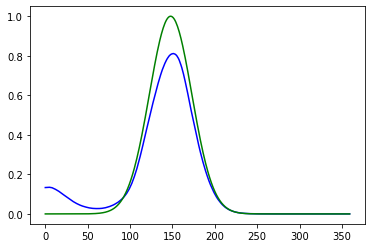

In [30]:
plt.plot(pred[0], 'b')
plt.plot(outp[0], 'g')
plt.show()

# Prediction Metrics Vector

In [20]:
classifier_lowest_hz = 32.70
classifier_lowest_cent = mir_eval.melody.hz2cents(np.array([classifier_lowest_hz]))[0]
classifier_cents_per_bin = 20
classifier_octaves = 6
classifier_total_bins = int((1200 / classifier_cents_per_bin) * classifier_octaves)
classifier_cents = np.linspace(0, (classifier_total_bins - 1) * classifier_cents_per_bin, classifier_total_bins) + classifier_lowest_cent

def to_weighted_average_cents(label):
    if label.ndim == 1:
        productsum = np.sum(label * classifier_cents)
        weightsum = np.sum(label)
        return productsum / weightsum
    if label.ndim == 2:
        productsum = np.dot(label, classifier_cents)
        weightsum = np.sum(label, axis=1)
        return productsum / weightsum
    raise Exception("label should be either 1d or 2d ndarray")

def to_local_average_cents(salience, center=None):
    """
    find the weighted average cents near the argmax bin
    """
    if not hasattr(to_local_average_cents, 'cents_mapping'):
        # the bin number-to-cents mapping
        to_local_average_cents.cents_mapping = (
                np.linspace(0, 7180, 360) + 1997.3794084376191)

    if salience.ndim == 1:
        if center is None:
            center = int(np.argmax(salience))
        start = max(0, center - 4)
        end = min(len(salience), center + 5)
        salience = salience[start:end]
        product_sum = np.sum(
            salience * to_local_average_cents.cents_mapping[start:end])
        weight_sum = np.sum(salience)
        return product_sum / weight_sum
    if salience.ndim == 2:
        return np.array([to_local_average_cents(salience[i, :]) for i in
                         range(salience.shape[0])])

    raise Exception("label should be either 1d or 2d ndarray")

def convert_cent_to_hz(c,fref=10.0):
    return fref*2**(c/1200.0)

def raw_pitch_accuracy_cent(true_cents, predicted_cents, cent_tolerence=50):
    counter_true = 0
    counter_false = 0
    for i in range(len(true_cents)):
        if abs(predicted_cents[i] - true_cents[i]) <= 50.0:
            counter_true += 1
        else:
            counter_false += 1
    if counter_true > 0:
        result = counter_true / (counter_true + counter_false) * 100
    else:
        result = 0
    return result

def raw_pitch_accuracy_hz(true_hz, predicted_hz):
    counter_true = 0
    counter_false = 0
    for i in range(len(true_hz)):
        if abs(predicted_hz[i] - true_hz[i]) <= (true_hz[i] * 0.02):
            counter_true += 1
        else:
            counter_false += 1
    if counter_true > 0:
        result = counter_true / (counter_true + counter_false) * 100
    else:
        result = 0
    return result

def standard_deviation_cent(true_cents, predicted_cents):
    diff = abs(predicted_cents - true_cents)
    avg = np.mean(diff)
    diff = np.square(diff - avg)
    sum = np.sum(diff)
    std_dev = np.sqrt((sum / (len(diff)-1)))
    return std_dev

def standard_deviation_hz(true_hz, predicted_hz):
    diff = abs(predicted_hz - true_hz)
    avg = np.mean(diff)
    diff = np.square(diff - avg)
    sum = np.sum(diff)
    std_dev = np.sqrt((sum / (len(diff)-1)))
    return std_dev

def mean_absolute_error_cent(true_cents, predicted_cents):
    diff = abs(predicted_cents - true_cents)
    mae = np.mean(diff)
    return mae

def mean_absolute_error_hz(true_hz, predicted_hz):
    diff = abs(predicted_hz - true_hz)
    mae = np.mean(diff)
    return mae

In [21]:
def histogram(diff):
# def histogram(true_hz, predicted_hz):
    #diff = abs(predicted_hz - true_hz)  
    n_bins = 250

    x = diff
    y = true_hz

    # fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

    # We can set the number of bins with the `bins` kwarg
    plt.figure()
    plt.hist(x, bins=n_bins)
    # axs[0].hist(x, bins=n_bins)
    #plt.xlim([-200, 200])
    plt.ylim([0, 5000])
    plt.xlabel("Error in Hertz")
    plt.ylabel("Number of Errors")
    plt.show()
    # axs[1].hist(x, bins=n_bins)


In [22]:
def prediction():
    predicted_c = []
    true_c = []
    for inp, outp in dataset_test:
        predicted = model.predict(inp)
        true_cents = to_local_average_cents(outp)
        true_c.append(true_cents)
        predicted_cents = to_local_average_cents(np.squeeze(predicted))
        predicted_c.append(predicted_cents)

    true_c = np.reshape(np.array(true_c), (1, (len(true_c)*len(true_c[0]))))
    true_c = np.squeeze(true_c)
    true_hz = convert_cent_to_hz(true_c)
    predicted_c = np.reshape(np.array(predicted_c), (1, (len(predicted_c)*len(predicted_c[0]))))
    predicted_c = np.squeeze(predicted_c)
    predicted_hz = convert_cent_to_hz(predicted_c)
    diff = true_hz - predicted_hz
    return predicted_hz, true_hz, true_c, predicted_c, diff

In [23]:
model.load_weights(os.path.join('/content/drive/MyDrive/BA_2021/deepf0/checkpoints', '20210428-212705', '50-0.18.hdf5'))

In [24]:
predicted_hz, true_hz, true_cent, predicted_cent, diff = prediction()

In [25]:
print(predicted_hz.shape)

(429824,)


In [ ]:
# diff = np.abs(diff)

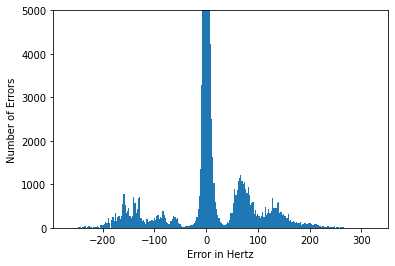

In [26]:
std_dev_hz = np.std(diff)
mae_hz = mean_absolute_error_hz(true_hz, predicted_hz)
mean_hz = np.mean(diff)
median_hz = np.median(diff)
# std_dev, avg = standard_deviation_hz(true_hz, predicted_hz)
rpa_cent = raw_pitch_accuracy_cent(true_cent, predicted_cent)
histo = histogram(diff)
quantile_05 = np.quantile(diff, 0.05)
quantile_95 = np.quantile(diff, 0.95)
min = np.min(diff)
max = np.max(diff)

In [27]:
print("Stdabweichung:", "%.2f" % std_dev_hz )
print("Avg in Hz:", "%.2f" % mean_hz)
print("MAE in Hz:", "%.2f" % mae_hz)
print("5% Quantil:", "%.2f" % quantile_05)
print("95% Quantil:", "%.2f" % quantile_95)
print("Median in Hz:", "%.2f" %median_hz)
print("Max in Hz:","%.2f" % max)
print("Min in Hz:", "%.2f" % min)
print("RPA in Cent:", "%.2f" % rpa_cent)

Stdabweichung: 39.89
Avg in Hz: 2.07
MAE in Hz: 13.21
5% Quantil: -8.38
95% Quantil: 68.99
Median in Hz: -0.00
Max in Hz: 322.11
Min in Hz: -265.66
RPA in Cent: 80.31


In [ ]:
def prediction_metrics():
    predicted_c = []
    true_c = []
    
    for inp, outp in dataset_test:
        predicted = model.predict(inp)
        true_cents = to_local_average_cents(outp)
        true_c.append(true_cents)
        predicted_cents = to_local_average_cents(np.squeeze(predicted))
        predicted_c.append(predicted_cents)
    
    true_c = np.reshape(np.array(true_c), (1, (len(true_c)*len(true_c[0]))))
    true_c = np.squeeze(true_c)
    true_hz = convert_cent_to_hz(true_c)
    predicted_c = np.reshape(np.array(predicted_c), (1, (len(predicted_c)*len(predicted_c[0]))))
    predicted_c = np.squeeze(predicted_c)
    predicted_hz = convert_cent_to_hz(predicted_c)
    
    # Raw Pitch Accuracy
    rpa_cent = raw_pitch_accuracy_cent(true_c, predicted_c)
    rpa_hz = raw_pitch_accuracy_hz(true_hz, predicted_hz)

    # Standard Deviation
    std_dev_cent = standard_deviation_cent(true_c, predicted_c)
    std_dev_hz = standard_deviation_hz(true_hz, predicted_hz)

    # Mean Absolute Error
    mae_cent = mean_absolute_error_cent(true_c, predicted_c)
    mae_hz = mean_absolute_error_hz(true_hz, predicted_hz)
    return rpa_cent, rpa_hz, std_dev_cent, std_dev_hz, mae_cent, mae_hz

In [ ]:
pred = prediction_metrics()

In [ ]:
print(pred[0], pred[1], pred[2], pred[3], pred[4], pred[5])


In [ ]:
inp, outp = next(iter(dataset_test))

In [ ]:
cents = to_weighted_average_cents(outp)
predicted = model.predict(inp, steps=1)
predicted = np.squeeze(predicted)